In [1]:
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import corner
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd

In [3]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Simple MCMC notebook for two-term power law 
$$ Y = a_1 X**b_1 + a_2 X**b_2 $$
Find a1, b1, a2, b2 given some uncertain obs of Y over some values of X

In [4]:
#..Set up simple power law model function
def two_term_one_dim(a1,a2,b1,b2,xvec):
    pvec = a1*xvec**b1 + a2*xvec**b2
    return pvec

In [5]:
#..Test out this function from values of xvec
xvec = np.linspace(0.1,100.,500)
pvec = two_term_one_dim(20.,1.,0.1,0.9,xvec)


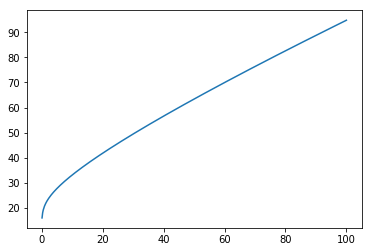

In [6]:
plt.plot(xvec,pvec)

In [7]:
help(pm.Uniform)

Help on class Uniform in module pymc3.distributions.continuous:

class Uniform(BoundedContinuous)
 |  Continuous uniform log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid lower, upper) = \frac{1}{upper-lower}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-3, 3, 500)
 |      ls = [0., -2]
 |      us = [2., 1]
 |      for l, u in zip(ls, us):
 |          y = np.zeros(500)
 |          y[(x<u) & (x>l)] = 1.0/(u-l)
 |          plt.plot(x, y, label='lower = {}, upper = {}'.format(l, u))
 |      plt.xlabel('x', fontsize=12)
 |      plt.ylabel('f(x)', fontsize=12)
 |      plt.ylim(0, 1)
 |      plt.legend(loc=1)
 |      plt.show()
 |  
 |  ========  =====================================
 |  Support   :math:`x \in [lower, upper]`
 |  Mean      :math:`\dfrac{lower + upper}{2}`
 |  Variance  :math:`\dfrac{(upper - lower)^2}{12}`
 |  ========

In [14]:
#..initialize random number generator
# adjust to test convergence
np.random.seed(11)

#..True parameter values
a1 = 20.
a2 = 1.
b1 = 0.1
b2 = 0.9

xvec = np.arange(2.0,21.,2)
#...Set the "obs"
Y = two_term_one_dim(a1,a2,b1,b2,xvec)

#..Set the obs error
sigma = 0.02

In [15]:
pl_model = pm.Model()

with pl_model:
    
    a1 = pm.Uniform('a1',lower=15.,upper=25.)
    a2 = pm.Uniform('a2',lower=0.7,upper=1.3)
    b1 = pm.Uniform('b1',lower=-0.3,upper=0.3)
    b2 = pm.Uniform('b2',lower=0.3,upper=1.3)
    
    xvec = np.arange(2.0,21.,2)

    #..Expected value of outcome
    mu = two_term_one_dim(a1,a2,b1,b2,xvec)
    
    #..Likelihood of observations
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma, observed=Y)

In [17]:
with pl_model:
    #trace = pm.sample(5000,tune=1000)
    # adjust tune to test convergence
    trace = pm.sample(5000,tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, a2, a1]
Sampling 4 chains: 100%|██████████| 36000/36000 [05:34<00:00, 107.54draws/s]
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5314548321877877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 499 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6476529377332707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7189007186522255, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2973 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0475524

In [11]:
print(trace)

<MultiTrace: 4 chains, 5000 iterations, 8 variables>


In [12]:
# import arviz
# pm.plot_posterior(trace)
#pm.traceplot(trace)
#pd.scatter_matrix(pm.trace_to_dataframe(trace))
df_trace = pm.trace_to_dataframe(trace)


(4, 20000)


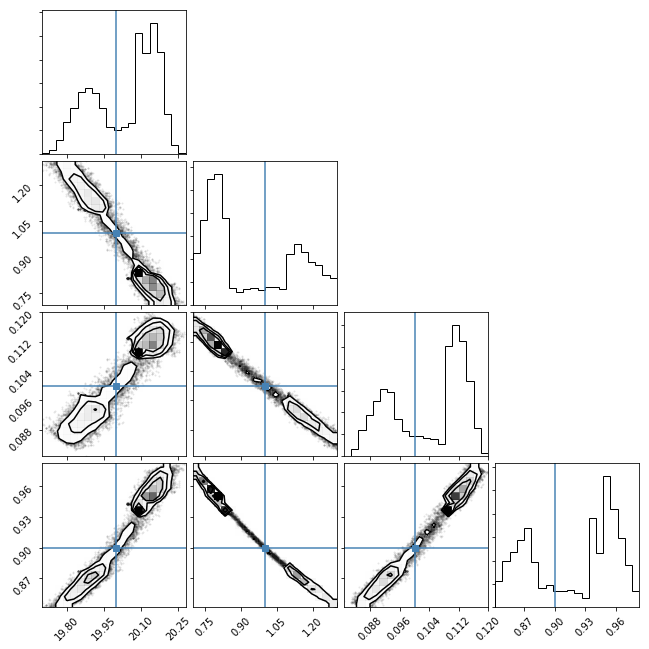

In [13]:
#..True parameter values
truths = np.array([20.,1.,0.1,0.9])

#samples = np.vstack((df_trace['a1'][:],df_trace['b1'][:],df_trace['a2'][:],df_trace['b2'][:]))
samples = np.vstack((df_trace['a1'][:],df_trace['a2'][:],df_trace['b1'][:],df_trace['b2'][:]))
print(samples.shape)
#fig,axes=corner.corner(samples.T,truths=truths)
figures = corner.corner(samples.T,truths=truths)

## Below stuff is for PyMC2 *** IGNORE ***

In [17]:
# #..Define variables and priors (bounded uniform)
# a1 = pymc.Uniform('a1',0.,40.)
# a2 = pymc.Uniform('a2',0.,2.)
# b1 = pymc.Uniform('b1',-1.0,1.0)
# b2 = pymc.Uniform('b2',-2.0,2.0)

#..Define variables and priors (bounded uniform, you can try Gaussian too)
a1 = pymc.Uniform('a1',15.,25.)
a2 = pymc.Uniform('a2',0.7,1.3)
b1 = pymc.Uniform('b1',-0.3,0.3)
b2 = pymc.Uniform('b2',0.3,1.3)

#..Define the observation points and the "true" observation
xvec = np.arange(2.0,21.,2)
print(xvec)
truth = np.array([20.,1.,0.1,0.9])
ydata = two_term_one_dim(truth[0],truth[1],truth[2],truth[3],xvec)
print(ydata)

#..Define the model
@pymc.deterministic
def y_model(a1=a1, a2=a2, b1=b1, b2=b2, xvec = xvec):
    pvec = two_term_one_dim(a1,a2,b1,b2,xvec)
    return pvec

#..Define the obs error standard deviation
sigma = 0.02

#..Define the likelihood (multivariate Gaussian w/ diagnonal error variance)
y = pymc.MvNormalCov('y',mu=y_model, C=sigma**2*np.eye(xvec.shape[0]), observed=True, value=ydata)

#..Bundle everything into a dict
model = dict(a1=a1,a2=a2,b1=b1,b2=b2,y_model=y_model,y=y)

[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
[ 23.30153523  26.45616935  28.94037679  31.12090744  33.12179058
  35.00150278  36.79275221  38.51589075  40.18454575  41.80834594]
blah
blah


In [ ]:
#..Run using the standard sampler (metropolis sampler with burn-in) w/independent proposal
S = pymc.MCMC(model)
S.sample(iter=2000000, burn=50000)

 [-----------------68%------            ] 1370784 of 2000000 complete in 330.1 sec

In [16]:
#..Run using the Adaptive Metropolis sampler (Haario 2001) w/covarying proposal
#..NOTE: you may need to run the cell two before this again to get this to work
S = pymc.MCMC(model)
S.use_step_method(pymc.AdaptiveMetropolis, [S.a1,S.a2,S.b1,S.b2], delay=10000)
S.sample(iter=2000000, burn=500000)

 [-----------------100%-----------------] 2000000 of 2000000 complete in 268.4 sec

(array([  8.00000000e+00,   0.00000000e+00,   1.50000000e+01,
          8.00000000e+00,   3.40000000e+01,   7.00000000e+01,
          1.09000000e+02,   1.90000000e+02,   3.58000000e+02,
          5.22000000e+02,   1.05600000e+03,   1.54800000e+03,
          2.14200000e+03,   3.17400000e+03,   3.84800000e+03,
          5.40000000e+03,   7.24100000e+03,   8.60800000e+03,
          1.01080000e+04,   1.19490000e+04,   1.30040000e+04,
          1.37860000e+04,   1.47340000e+04,   1.53450000e+04,
          1.71590000e+04,   1.95390000e+04,   2.53100000e+04,
          5.06560000e+04,   1.57510000e+04,   4.57600000e+03,
          1.97400000e+03,   9.26000000e+02,   4.33000000e+02,
          2.73000000e+02,   1.08000000e+02,   2.20000000e+01,
          4.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([ -1.13815611e+00,  -1.09748945e+00,  -1.05682279e+00,
         -1.01615613e+00,  -9.75489475e-01,  -9.34822815e-01,
         -8.94156156e-01,  -8.53489496e-01

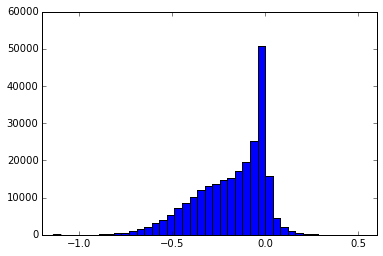

In [93]:
#..Some stats
plt.hist(S.trace('y_model')[:,0],bins=40)

(4, 1500000)


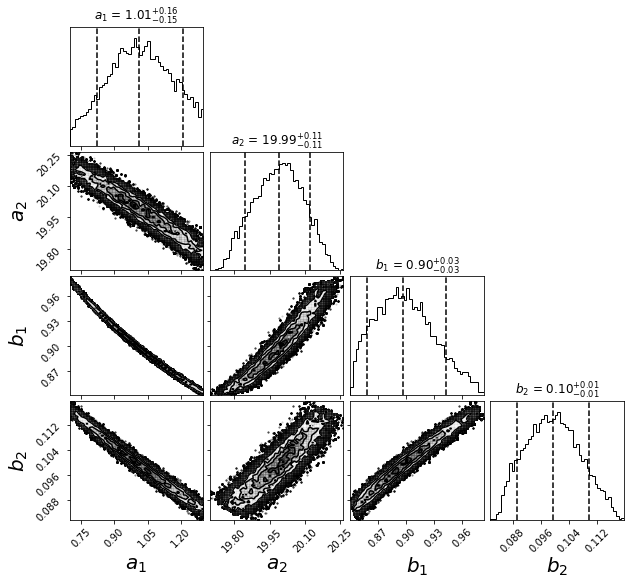

In [19]:
#..Plot the posterior joint parameter PDF (as a 2D and 1D marginal corner plot)

labels  = ['$a_1$', '$a_2$','$b_1$','$b_2$']
#samples = np.vstack((S.trace('a1')[:],S.trace('a2')[:],S.trace('b1')[:],S.trace('b2')[:]))
samples = np.vstack((S.trace('a2')[:],S.trace('a1')[:],S.trace('b2')[:],S.trace('b1')[:]))
print(samples.shape)

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(5,5,1)
#plt.plot([0,1],[0,1])
label_kwargs = {'fontsize':'20'}
#fig = triangle.corner(samples.T,labels=labels,truths=truth,label_kwargs=label_kwargs)
# fig,axes = triangle.corner(samples.T,labels=labels,truths=truth,
#                       quantiles=[.1,.5,.9],truth_color='r',
#                       show_titles=True,
#                       bins=50,
#                       label_kwargs=label_kwargs,return_axes=True)


#..NOTE the default behavior only returns fig
#fig,axes = corner.corner(samples.T,labels=labels,truths=truth,
fig = corner.corner(samples.T,labels=labels,truths=truth,
                      quantiles=[.1,.5,.9],truth_color='r',
                      show_titles=True,
                      bins=50,
                      label_kwargs=label_kwargs)
fig.set_size_inches(9,8)

fig.savefig('mcmc_twoterm_lowerr10.png',dpi=150)
#fig.suptitle('Damped Harmonic Oscillator parameter uncertainty', fontsize=22,fontweight='bold',y=1.05)
#fig.savefig('mcmc_dampharm.png',dpi=150)